### AM207 Final Project Fantasy Sport 
Team Members: Andy Shi, Hidenori Tanaka, Hyungmok Sun, Xingchi Dai

In [181]:
# Import some necessary packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit
import copy
import scipy.stats 
import pandas as pd
import pymc as pm

import numpy as np


In [148]:
# Import player/salary csvs
player_df = pd.read_csv('fantasy_stats_2016.csv')[['Player','PTS']]
player_df = player_df[player_df['PTS'] != "PTS"]
player_df['PTS'] = player_df['PTS'].map(lambda x: float(x))
player_df = pd.DataFrame(player_df.groupby('Player')['PTS'].mean())
player_df["Player"] = player_df.index
player_df = player_df.reset_index(drop=True)
player_df.head()

,PTS,Player
0,7.1,Aaron Brooks
1,9.2,Aaron Gordon
2,0.9,Aaron Harrison
3,2.5,Adreian Payne
4,15.2,Al Horford


In [149]:
salary_df = pd.read_csv('salary.csv',header=1)[['Player','2015-16']]
salary_df = salary_df[salary_df['Player'] != "Player"]
salary_df = salary_df[salary_df['2015-16'] != "Salary"]
salary_df['2015-16'] = salary_df['2015-16'].map(lambda x: int(x.lstrip('$')))
salary_avg = pd.DataFrame(salary_df.groupby('Player')['2015-16'].mean())
salary_avg["Player"] = salary_avg.index
salary_avg = salary_avg.reset_index(drop=True)
salary_avg.head()

,2015-16,Player
0,2000000,Aaron Brooks
1,4171680,Aaron Gordon
2,452059,Aaron Gray
3,525093,Aaron Harrison
4,60000,Adonis Thomas


In [150]:
# Merge the two dfs into one 
df = player_df.merge(salary_df, on="Player" ,how='inner')
df = df[df['Player'] != "Player"]
df.head()

,PTS,Player,2015-16
0,7.1,Aaron Brooks,2000000
1,9.2,Aaron Gordon,4171680
2,0.9,Aaron Harrison,525093
3,2.5,Adreian Payne,1938840
4,15.2,Al Horford,12000000


### Summary
Up to here, we have a clean dataframe containning player name, and "point per game". The next step is to do Simulated Annealing. 

### Use Simulated Annealing to optimize the best line-up

Similar to the previous homework problem, here we decided to use SA to optimize our best line-up as a baseline model. We also did greedy algorithm first to compare with our result later.

### Greedy Algorithm
The greedy algorithm is to find AT LEAST 12 players as our line-up(5 players on the court while 7 players on the bench). Besides this constraints, we also limit our yearly salary we paid for one team. From [http://www.basketball-reference.com/contracts/], I decided to set the limit for 12 players $50,000,000. and choose the best 12 players

The easiest way is to sort player by their pts(values), and pick up 12 players which under our salary restriction.

In [211]:
# number of players
N = 12
N_min = 5
# money we would like to pay in million dollars
M = 55
# PTS for players
pts = df['PTS'].map(lambda x: float(x)).values
# the salary is in million unit
salary = df['2015-16'].values/1000000.0
players = df['Player'].values

In [152]:
# Here we calculate the ratio
sort_idx = np.argsort(pts)

In [166]:
# Here I print out the best 12 players under the naive method
total_num = 0
total_value = 0
total_sal = 0
line_up = []
#loop through all players
for i in range(len(pts)):
    # we only need 12 player
    if(total_num > 11):
        break;
    # pick one, check if it will be larger than our the total money
    if(total_sal + salary[sort_idx[-i]] > M):
        #take the last one out
        total_num -= 1
        total_sal -= salary[line_up[-1]]
        total_value -= pts[line_up[-1]]
        del line_up[-1]
        continue;
    else:
        total_num += 1
        total_sal += salary[sort_idx[-i]]
        total_value += pts[sort_idx[-i]]
        line_up.append(sort_idx[-i])

In [168]:
# print out line_up idx and summary
print "The line-up under naive method is:\n"
for idx in line_up:
    print players[idx]
print "the total value is:", total_value
print "the total salary we would pay", total_sal
print "we have", total_num, "players"

The line-up under naive method is:

J.J. O'Brien
Stephen Curry
James Harden
Isaiah Thomas
Joe Johnson
J.R. Smith
Ish Smith
Omri Casspi
C.J. Miles
Harrison Barnes
Michael Carter-Williams
Jordan Hamilton
the total value is: 176.433333333
the total salary we would pay 54.35657
we have 12 players


### Summary
Actually the naive method does a very good job here, judging by the fact that the money we paid is really close to our limit. and it seems total value is legit. We will see how simulated annealing could improve this result. 

### Simulated Annealing
Those two restrictions still apply in this situation. I chose the result from previous section as my starting point.

In [180]:
# two functions to calculate values and salary of players we picked
def playersValues(line_up,value = pts):
    return sum(line_up * value)
def playersSalaries(line_up,salary = salary):
    return sum(line_up * salary)

In [182]:
# function we randomly take players out of our line-up
def firePlayer(line_up,num_fired):
    proposed_line = copy.deepcopy(line_up)
    for i in range(num_fired):
        idx = np.random.randint(0,len(line_up))
        proposed_line[idx] = False 
    return proposed_line

In [183]:
def hirePlayer(line_up,num_hired):
    proposed_line = copy.deepcopy(line_up)
    for i in range(num_hired):
        idx = np.random.randint(0,len(line_up))
        proposed_line[idx] = True 
    return proposed_line

In [279]:
# function for simulated annealing
# items: all items we could choose from
# init_temp: initial temperature 
# thermostat: linear factor to decrease the temperature 
# ftol, itol, otol: tolerance values for stopping 
# ftol: Not changing much anymore
# itol: maximum number of iterations
# otol: objective goal reached
# reannealing: schedule for reheating

def simulated_annealing(prev,init_temp, thermostat, ftol, itol, otol, reannealing):
    # ===============
    # SET THESE FOR DIAGNOSTICS
    # ================
    best = []
    m=10000     
    distsize=otol+1
    temperature = init_temp   
    best_line_up = prev
    max_E = playersValues(prev)
    #number of accepted steps
    it = 0                    
    # Initialize my energy values
    prev_E = playersValues(prev)  
    #number of iterations
    atp=0
    didPlot = False
    while it >=0:
        # adaptive step size
        L = np.floor(np.sqrt(temperature)).astype(int)
        #This step is to add new points in neighbors
        propose_line = hirePlayer(prev,L)
        new_num_player = sum(propose_line)     
        
        # Here check the items weights
        new_salary = playersSalaries(propose_line)
       
        # Here is my condition, loop if new_weight is larger than W
        while(new_salary > M or new_num_player < N_min or new_num_player > N):
            if (new_salary > M):
                propose_line = firePlayer(propose_line,L)
            if(new_num_player < N_min):
                propose_line = hirePlayer(propose_line,L)
            if(new_num_player > N):
                propose_line = firePlayer(propose_line,L)
            new_salary = playersSalaries(propose_line)
            new_num_player = sum(propose_line)
        # Here I know everything satisfies conditions
        # Now it's time to check the energy            
        new_E = playersValues(propose_line)
        # Here I got my new_E 
        deltaE  =  new_E - prev_E 
        # if the new energy is larger, I will take it
        if new_E > prev_E:
            prev  = propose_line
            prev_E = new_E
            best.append(new_E)
            #tract the best sol
            if(new_E > max_E):
                max_E = new_E
                best_line_up = prev
            it = it+1
            atp += 1
        elif np.random.rand() < np.exp(deltaE/temperature):
            prev  = propose_line
            prev_E = new_E 
            best.append(new_E)
            it = it+1
            atp += 1

        if(atp % 1000 == 0):
            print "ran", atp,"already"
        if it % reannealing == 0:
            temperature = thermostat * temperature;
            compl_temp=0;
            if temperature < 0.01:
                temperature = 1
    
        if len(best)>m and np.std(best[-m:])/np.mean(best[-m:]) < ftol:
            print 'ftol'
            break
        if atp >itol:
            print 'itol'
            break
        if len(best)> 0 and best[-1] >= otol:
            print 'otol'
            print otol
            print best[-1]
            break
    return best, prev, best_line_up

In [171]:
#the init line_up info
init_line_up = line_up

In [280]:
#set all players to false except those we picked fro the previous section
start = [False] * len(players)
for idx in init_line_up:
    start[idx] = True

In [281]:
best_results, new_line_up, best_line_up = simulated_annealing(start, 3.0, 0.9, 0.01, 10000, 300, 1000)

ran 0 already
ran 0 already
ran 0 already
ran 0 already
ran 1000 already
ran 1000 already
ran 1000 already
ran 2000 already
ran 2000 already
ran 2000 already
ran 2000 already
ran 3000 already
ran 4000 already
ran 5000 already
ran 6000 already
ran 7000 already
ran 8000 already
ran 9000 already
ran 10000 already
itol


The best result is: 233.366666667


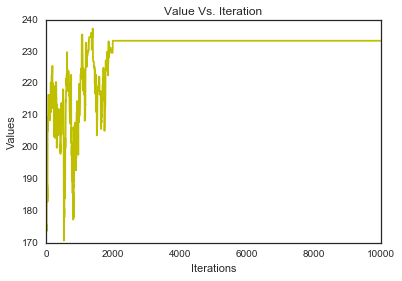

In [288]:
plt.plot(best_results,c='y')
plt.title("Value Vs. Iteration")
plt.xlabel("Iterations")
plt.ylabel("Values")
print "The best result is:", best_results[-1]

In [283]:
np.max(best_results)

237.19999999999999

In [284]:
# Here I print out players
print "The best line up given by SA is:"
sort_line = np.argsort(best_line_up)
SA_result = []
for i in range(1,np.sum(best_line_up)+1):
    SA_result.append(sort_line[-i])
    print players[sort_line[-i]]
    

The best line up given by SA is:
Anthony Davis
Isaiah Thomas
Evan Fournier
Giannis Antetokounmpo
Dahntay Jones
Damian Lillard
Hassan Whiteside
DeMarcus Cousins
Michael Beasley
Stephen Curry
C.J. McCollum
Jordan Clarkson


In [285]:
print "The money we paid for this line-up is: ",playersSalaries(best_line_up)
print "The value of this line-up is: ",playersValues(best_line_up)

The money we paid for this line-up is:  53.228594
The value of this line-up is:  237.2


### Table 1

| Naive Method            | Simulated Annealing   | Notes                           |
|-------------------------|-----------------------|---------------------------------|
| Stephen Curry           | Stephen Curry         | The best shooter in NBA history | 
| James Harden            | Jordan Clarkson       |                                 |   
| Jordan Hamilton         | C.J. McCollum         |                                 |   
| Michael Carter-Williams | Michael Beasley       |                                 |  
| Harrison Barnes         | DeMarcus Cousins      |                                 | 
| C.J. Miles              | Hassan Whiteside      |                                 |   
| Omri Casspi             | Damian Lillard        |                                 |
| Ish Smith               | Dahntay Jones         |                                 |   
| J.R. Smith              | Giannis Antetokounmpo |                                 |   
| Joe Johnson             | Evan Fournier         |                                 |  
| Isaiah Thomas           | Isaiah Thomas         | Boston Celtics, PTS = 22.2      |   
| J.J. O'Brien            | Anthony Davis         |                                 |  